## **Installing Packages**

In [1]:
!pip install textblob
!pip install sentencepiece  
!pip install transformers
!pip install textstat
!pip install language-tool-python
!pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 4.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 6.0 MB/s 
     |████████████████████████████████| 7.6 MB 35.8 MB/s 
     |████████████████████████████████| 182 kB 53.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 105 kB 5.4 MB/s 
     |████████████████████████████████| 2.0 MB 41.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 2.6 MB/s 
  Cre

Restart Runtime after installing 

## **Importing Packages**

In [23]:
import re
import nltk 
import spacy
import textstat
import numpy as np
import pandas as pd
import seaborn as sn 
from textblob import Word
import matplotlib.pyplot as plt
import language_tool_python

from google.colab import files
from nltk.tag import pos_tag
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from sentence_transformers import SentenceTransformer, util

nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")
tool = language_tool_python.LanguageTool('en-US')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Reading Data From Google Drive**

In [24]:
from google.colab import drive
drive.mount('/content/drive')
Data_Essay_01 = pd.read_csv("/content/drive/MyDrive/IntelliTech-DataSet/EssaySet01.csv")
Data_Essay_01.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,ID,Essay,Rater_1 Score,Rater_2 Score,Total Score
0,1,"Dear local newspaper, I think effects computer...",4.0,4.0,8.0
1,2,"Dear @CAPS1 @CAPS2, I believe that using compu...",5.0,4.0,9.0
2,3,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4.0,3.0,7.0
3,4,"Dear Local Newspaper, @CAPS1 I have found that...",5.0,5.0,10.0
4,5,"Dear @LOCATION1, I know having computers has a...",4.0,4.0,8.0


# **Feature Extraction**

## **Essay Pre Processing**

In [25]:
def Remove_NER(Essay):
  """
    Removes Named Entity Recognition (NER) from each essay

    Args:
      Sentence: Essay of each student 
    
    Returns: 
      String

  """
  token = Essay.split()
  newTokens = []
  # print(token)
  for i in range(len(token)):
    if "@" in token[i]:
      if "," in token[i]:
        newTokens.append(",")
      elif "." in token[i]:
        newTokens.append(".")
      elif "!" in token[i]:
        newTokens.append("!")
    else:
      newTokens.append(token[i])

  return " ".join(newTokens)
  # return ' '.join (word for word in Essay.split(' ') if not word.startswith('@'))
def Remove_NER2(Essay):
    return ' '.join (word for word in Essay.split(' ') if not word.startswith('@'))
def Remove_Punctuations(sentence):
  """
    Removes punctuations from text
    Args:
      sentence: Essay of each student
    
    Returns: 
      String
  """
  punctuations = '''!()-[]{};:"\,/'<>.?@#$%^&*_~'''
  newSentence = ""
  for word in sentence:
      if (word in punctuations):
          newSentence = newSentence + " "
      else: 
          newSentence = newSentence + word
  return newSentence

def LowerCase_Words(Essay):
  """
    Lower case all the words in an essay

    Args:
      Sentence: Essay of each student
    
    Returns: 
      String
  """
  return re.sub('[0-9]+','', Essay).lower() 

def Tokenize_Essay(Essay):
    """
      Create Tokens of each Essay

      Args:
        Essay: Essay of each student
      
      Returns: 
        String
    """
    Preprocessed = Remove_Punctuations(Essay)
    return " ".join(word_tokenize(Preprocessed))

def Remove_White_Spaces(Essay):
  """
    Removes Extra White Spaces

    Args:
      Essay: Essay of each student
    
    Returns: 
      String
  """
  return " ".join(Essay.split())

def Remove_Special_Characters(Essay):
  """
    Removes Special Characters from Essay

    Args:
      Essay: Essay of each student
    
    Returns: 
      String
  """
  new_text = re.sub(r"[^a-zA-Z0-9 ]", "", Essay)
  return new_text

## **Basic Count Features**

This section will cover:


*   Counting Sentences per Essay
*   Counting Words per Essay
*   Counting Characters per Essay
*   Average Words per Essay
*   Counting Syllables
*   Percentage Of Hard Words




#### Counting Sentences per Essay

In [26]:
def Sentence_Count(Essay):
    """
    Counts sentences in an essay

    Args:
      Essay: Essay of each student 
    
    Returns: 
      int
  """
    sentence_no = nltk.sent_tokenize(Essay)
    return len(sentence_no)

In [27]:
Data_Essay_01['Sent_Count'] = Data_Essay_01['Essay'].apply(Sentence_Count)
Data_Essay_01.sample()

,ID,Essay,Rater_1 Score,Rater_2 Score,Total Score,Sent_Count
1733,1738,"Dear readers, People around the world are star...",4.0,3.0,7.0,11


#### Counting Words per Essay

**Observation:** These word count are more than the original count coz of nltk tokenization. Punctations are treated as seperate words.


In [28]:
def Word_Count(Essay):
  """
    Counts words in an essay

    Args:
      Essay: Essay of each student 
    
    Returns: 
      int  
  """ 
  word_no = nltk.word_tokenize(Essay)
  return len(word_no)

In [29]:
Data_Essay_01['Word_Count'] = Data_Essay_01['Essay'].apply(Word_Count)
Data_Essay_01.sample()

,ID,Essay,Rater_1 Score,Rater_2 Score,Total Score,Sent_Count,Word_Count
252,253,"Dear @CAPS1, @CAPS2 you think computer's are g...",3.0,3.0,6.0,14,259


#### Counting Characters per Essay

In [30]:
def Char_Count(Essay):
  """
    Counts characters in an essay

    Args:
      Essay: Essay of each student 
    
    Returns: 
      int
  """
  return len([character for character in Essay])

In [31]:
Data_Essay_01['Char_Count'] = Data_Essay_01['Essay'].apply(Char_Count)
Data_Essay_01.sample()

,ID,Essay,Rater_1 Score,Rater_2 Score,Total Score,Sent_Count,Word_Count,Char_Count
388,391,"People should ues computers, they do benefit t...",6.0,6.0,12.0,33,601,2897


#### Average Word Length of Essay

In [32]:
def Avg_Word_Count(Essay):
  """
    Calculates Average Word Count In An Essay Set

    Args:
      Essay: Essay of each student 
    
    Returns: 
      float
      
  """
  word_list = nltk.word_tokenize(Essay)
  total = sum(map(len, word_list))/len(word_list)
  return total

In [33]:
Data_Essay_01['Avg_Word_Count'] = Data_Essay_01['Essay'].apply(Avg_Word_Count)
Data_Essay_01.sample()

,ID,Essay,Rater_1 Score,Rater_2 Score,Total Score,Sent_Count,Word_Count,Char_Count,Avg_Word_Count
1223,1227,On today's society many new technologys have b...,4.0,4.0,8.0,14,200,1012,4.185


#### Average Sentence Length of Essay

In [34]:
def Average_Sentence_Length(Word_Count,Sent_Count):
  
  average_sentence_length = float(Word_Count / Sent_Count)
  return average_sentence_length

In [35]:
Data_Essay_01['Avg_Sentence_Length']=Data_Essay_01.apply(lambda row :Average_Sentence_Length(row["Word_Count"],row["Sent_Count"]),axis=1)

#### Counting Syllables
       Primarily used in Readability scores.

In [36]:
def Syllable_Count(text):
  return textstat.syllable_count(text, lang='en_US')

In [37]:
Data_Essay_01['Preprocessed_Essay'] = Data_Essay_01['Essay'].apply(Remove_NER)
Data_Essay_01['Preprocessed_Essay'] = Data_Essay_01['Preprocessed_Essay'].apply(Tokenize_Essay)
Data_Essay_01["Syllable_Count"] = Data_Essay_01['Preprocessed_Essay'].apply(Syllable_Count)

#### Percentage of Difficult Words
    Primarily used in Readability scores.
    Execution Time: 30 mins +




In [38]:
def Difficult_Words_Count(text):
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(text)

    # Find all words in the text
    words = []
    sentences = nltk.sent_tokenize(text)
    for sentence in sentences:
        tokens=nltk.word_tokenize(sentence)
        for token in tokens:
          words.append(token)

    # difficult words are those with syllables >= 2 ,Easy words are provided by textstat library.
    diff_words_set = set()

    #Syllabes are those words which have a break in between for example , book has a single syllable while reading has two.
    for word in words:
      syllable_count=Syllable_Count(word)
      if word not in nlp.Defaults.stop_words and syllable_count >= 2:
            diff_words_set.add(word)
 
    return len(diff_words_set)

In [39]:
Data_Essay_01["Difficult_Word_Count"] = Data_Essay_01["Preprocessed_Essay"].apply(Difficult_Words_Count)

## **Parts Of Speech Counts**

This section will cover:


*   Counting Nouns per Essay
*   Counting Adjectives per Essay
*   Counting Proper Nouns per Essay
*   Counting Adverbs per Essay
*   Counting Conjunctions per 

```
Execution Time: 2 minutes
```

Removing NERs, Punctuations and Lower Casing

In [40]:
Data_Essay_01['Preprocessed_Essay'] = Data_Essay_01['Essay'].apply(Remove_NER)
Data_Essay_01['Preprocessed_Essay'] = Data_Essay_01['Preprocessed_Essay'].apply(Tokenize_Essay)
Data_Essay_01.head()

,ID,Essay,Rater_1 Score,Rater_2 Score,Total Score,Sent_Count,Word_Count,Char_Count,Avg_Word_Count,Avg_Sentence_Length,Preprocessed_Essay,Syllable_Count,Difficult_Word_Count
0,1,"Dear local newspaper, I think effects computer...",4.0,4.0,8.0,16,386,1875,3.984456,24.125000,Dear local newspaper I think effects computers...,436,42
1,2,"Dear @CAPS1 @CAPS2, I believe that using compu...",5.0,4.0,9.0,20,464,2288,4.030172,23.200000,Dear I believe that using computers will benef...,567,57
2,3,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4.0,3.0,7.0,14,313,1541,4.035144,22.357143,Dear More and more people use computers but no...,385,45
3,4,"Dear Local Newspaper, @CAPS1 I have found that...",5.0,5.0,10.0,27,611,3165,4.328969,22.629630,Dear Local Newspaper I have found that many ex...,715,95
4,5,"Dear @LOCATION1, I know having computers has a...",4.0,4.0,8.0,30,517,2569,4.071567,17.233333,Dear I know having computers has a positive ef...,657,61


In [41]:
def Pos_Tag_Count(Essay):
  """
    Counts Parts of Speech in an Essay

    Args:
      Essay: Essay of each student 
    
    Returns: 
      int,int,int,int,int,int    
  """
  tagged_doc = nlp(Essay)

  adj_count=0
  verb_count=0
  noun_count=0
  pNoun_count=0
  adverb_count=0
  conj_count=0

  for token in tagged_doc:

    if(token.pos_ == 'ADJ'):
      adj_count+=1
    
    elif(token.pos_ =='NOUN'):
      noun_count+=1

    elif (token.pos_ =='PRON'):
      pNoun_count+=1

    elif (token.pos_ =='VERB'):
      verb_count+=1

    elif (token.pos_ =='ADV'):
      adverb_count+=1
    
    elif(token.pos_=='CCONJ'):
      conj_count+=1

  return verb_count,noun_count, adj_count, conj_count, adverb_count,pNoun_count

In [42]:
Data_Essay_01['Verb_Count'], Data_Essay_01['Noun_Count'], Data_Essay_01['Adj_Count'], Data_Essay_01['Conj_Count'], Data_Essay_01['Adverb_Count'], Data_Essay_01['pNoun_Count']=zip(*Data_Essay_01["Preprocessed_Essay"].map(Pos_Tag_Count))
Data_Essay_01.sample()

,ID,Essay,Rater_1 Score,Rater_2 Score,Total Score,Sent_Count,Word_Count,Char_Count,Avg_Word_Count,Avg_Sentence_Length,Preprocessed_Essay,Syllable_Count,Difficult_Word_Count,Verb_Count,Noun_Count,Adj_Count,Conj_Count,Adverb_Count,pNoun_Count
1544,1549,"To whomever this @MONTH1 concern, @ORGANIZATIO...",3.0,3.0,6.0,9,157,818,4.343949,17.444444,To whomever this concern almost everyone has t...,198,22,27,36,9,7,3,13


In [ ]:
Data_Essay_01.to_csv("Output_1.csv")
files.download('/content/Output_1.csv')

## **Evaluating Writing Attributes**

This section will cover:


*   Style
*   Content
*   Semantic
*   Semantic Coherence & Consistency 
*   Connectivity
*   Readibility Scores


### **Style**

This section will cover:


*   Mechanics
*   Grammar
*   Lexical Sophistication



#### **Mechanics**

This section will cover:


*   Counting Spelling Mistakes
*   Correcting Spelling Mistakes
*   Checking Punctuations
*   Counting Punctuations
*   Checking Capitalization



##### Counting Spelling Mistakes


```
Execution Time: 30 mins +
```



In [44]:
def Check_Spelling(Sentence):
  """
    Checks spelling of each word

    Args:
      word: Words (Tokens) of each essay 
    
    Returns: 
      int
  """
  count = 0
  Sentence = word_tokenize(Sentence)
  for word in Sentence:
    word = Word(word)
  
    result = word.spellcheck()

    # result [0][0] contains the bool value if the spelling is correct or not
    # result [0][1] contains the confidence for the suggest correct spelling

    if word != result[0][0]:
      if(result[0][1] > 0.9 and not(wordnet.synsets(word)) and not("/" in word) and not (word == "If" or word == "if")):
        count = count + 1
        
  return count

In [45]:
Data_Essay_01["Preprocessed_Essay"] = Data_Essay_01["Essay"].apply(Remove_NER)

In [ ]:
# Data_Essay_01["Spelling_Mistakes_Count"] = Data_Essay_01["Preprocessed_Essay"].map(Check_Spelling)
Data_Essay_01["Spelling_Mistakes_Count"] = Data_Essay_01["Preprocessed_Essay"].apply(Check_Spelling)

##### Correcting Spelling Mistakes via LanguageTool
     This is for Grammer

In [47]:
def Spelling_Error_Correct(essays):
    matches = tool.check(essays)
    is_bad_rule = lambda rule: rule.category == 'GRAMMAR'
    matches = [rule for rule in matches if not is_bad_rule(rule)]
    # print(matches[0].category)
    language_tool_python.utils.correct(essays, matches)   # to correct it
    return essays

In [48]:
Data_Essay_01["Without_White_Spaces"] = Data_Essay_01["Essay"].apply(Remove_White_Spaces)
Data_Essay_01['Essay_SpellingCorrected_LT'] = Data_Essay_01['Without_White_Spaces'].apply(Spelling_Error_Correct)

##### Counting Number Of Punctuations

In [49]:
def Count_Punctuations(Essay):
  """
    Counts Punctuations used in an Essay

    Args:
      Essay: Essay of each student 
    
    Returns: 
      int,int,int,int,int
      
  """
  count_fullstops = 0
  count_exclamation = 0
  count_comma = 0
  count_hyphens = 0
  count_questionmark = 0

  tokens = word_tokenize(Essay)

  for word in tokens:
    if word == ".":
      count_fullstops += 1
    elif word == "!":
      count_exclamation += 1
    elif word == "?":
      count_questionmark += 1
    elif word == ",":
      count_comma += 1
    elif word == "-":
      count_hyphens += 1

  return count_fullstops , count_exclamation , count_comma , count_questionmark , count_hyphens

In [50]:
Data_Essay_01["Count_Fullstops"] , Data_Essay_01["Count_Exclamation"] , Data_Essay_01["Count_Comma"] , Data_Essay_01["Count_Questionmark"] , Data_Essay_01["Count_Hyphens"] = zip(*Data_Essay_01["Essay"].map(Count_Punctuations))
Data_Essay_01.sample()

,ID,Essay,Rater_1 Score,Rater_2 Score,Total Score,Sent_Count,Word_Count,Char_Count,Avg_Word_Count,Avg_Sentence_Length,...,Adverb_Count,pNoun_Count,Spelling_Mistakes_Count,Without_White_Spaces,Essay_SpellingCorrected_LT,Count_Fullstops,Count_Exclamation,Count_Comma,Count_Questionmark,Count_Hyphens
1756,1761,"Dear @PERSON1, Computers are very helpful in d...",4.0,4.0,8.0,21,415,1941,3.8,19.761905,...,19,61,7,"Dear @PERSON1, Computers are very helpful in d...","Dear @PERSON1, Computers are very helpful in d...",6,15,14,0,0


##### Checking Capitalization Mistakes

In [51]:
def Check_Capitalization(Essay):
  """
    Checks capitalization in each sentence of an essay

    Args:
    Essay: Words (Tokens) of each essay 

    Returns: 
    int

  """
  count = 0

  words = Essay.split()
  alreadyCounted_Words = []
  
  for i in range(len(words) - 1):
    if (i == 0):                                                    # Checking Capital Letter at the start of Sentence
      if words[i] != words[i].title():
        alreadyCounted_Words.append(words[i])
        count = count + 1
    elif "@" in words[i]:
      continue
    elif words[i] == '.' or words[i] == '"':                         # Checking Capital Letters in start of every sentence & start of every quote
      match = words[i+1]
      if match != words[i+1].title():
        alreadyCounted_Words.append(words[i])
        count = count + 1
        i = i + 1
    
    # Check if capital in middle 
    
  # Checking if all proper nouns are capital or not

  tagged_sent = nlp(Essay)

  for i in range(len(tagged_sent)):
    if tagged_sent[i].pos_ == "PROPN":
      # print(tagged_sent[i]) 
      word = tagged_sent[i].text 
      if word in alreadyCounted_Words:
        alreadyCounted_Words.remove(word)
      elif word != word.title():
        count = count + 1

  return count

In [52]:
Data_Essay_01["Preprocessed_Essay"] =  Data_Essay_01["Essay"].apply(Remove_NER)
Data_Essay_01["Capitalization_Errors"] = Data_Essay_01["Preprocessed_Essay"].apply(Check_Capitalization)
Data_Essay_01.sample()

,ID,Essay,Rater_1 Score,Rater_2 Score,Total Score,Sent_Count,Word_Count,Char_Count,Avg_Word_Count,Avg_Sentence_Length,...,pNoun_Count,Spelling_Mistakes_Count,Without_White_Spaces,Essay_SpellingCorrected_LT,Count_Fullstops,Count_Exclamation,Count_Comma,Count_Questionmark,Count_Hyphens,Capitalization_Errors
1001,1004,"Dear @CAPS1, @CAPS2 people have computers in t...",3.0,3.0,6.0,6,183,957,4.31694,30.5,...,20,3,"Dear @CAPS1, @CAPS2 people have computers in t...","Dear @CAPS1, @CAPS2 people have computers in t...",6,0,4,0,0,0


In [53]:
Data_Essay_01.to_csv("Output_2.csv")
files.download('/content/Output_2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### Checking Punctuation Mistakes **(Incomplete)**



In [30]:
from transformers import AutoTokenizer, AutoModelForTokenClassification , pipeline

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('oliverguhr/fullstop-punctuation-multilang-large')
model = AutoModelForTokenClassification.from_pretrained('oliverguhr/fullstop-punctuation-multilang-large')
pun = pipeline('ner' , model = model , tokenizer = tokenizer)

In [ ]:
tags = pun(text)

Updated_string = ''

for output in tags:
  result = output['word'].replace('▁' , ' ') + output['entity'].replace('0', '')
  Updated_string += result

Updated_string

In [ ]:
def Punctuation_Errors(essays):
    matches = tool.check(essays)
    is_bad_rule = lambda rule: rule.category == 'PUNCTUATION'
    matches = [rule for rule in matches if is_bad_rule(rule)]
    return len(matches)

In [ ]:
Data_Essay_01["Without_White_Spaces"] = Data_Essay_01["Essay"].apply(Remove_White_Spaces)

In [ ]:
Data_Essay_01["Punctuation_Errors"] = Data_Essay_01["Without_White_Spaces"].apply(Punctuation_Errors)

#### **Grammar Error Detection**

In [54]:
df1 = Data_Essay_01[['Essay_SpellingCorrected_LT', 'Sent_Count']]
df1.head()

,Essay_SpellingCorrected_LT,Sent_Count
0,"Dear local newspaper, I think effects computer...",16
1,"Dear @CAPS1 @CAPS2, I believe that using compu...",20
2,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",14
3,"Dear Local Newspaper, @CAPS1 I have found that...",27
4,"Dear @LOCATION1, I know having computers has a...",30


In [55]:
def Grammar_Errors(essays):
    matches = tool.check(essays)
    is_bad_rule = lambda rule: rule.category == 'GRAMMAR'
    matches = [rule for rule in matches if is_bad_rule(rule)]
    errors = []
    #language_tool_python.utils.correct(text, matches)   # to correct it
    for i in range(0, len(matches)):
      errors.append(matches[i].ruleId)  # or category of the error (Misc, Whitespace, Typography)
    return len(matches), errors

In [56]:
Data_Essay_01['Grammar_Error_Count'], Data_Essay_01['Grammar_Error_List'] = zip(*df1['Essay_SpellingCorrected_LT'].map(Grammar_Errors))

In [57]:
Data_Essay_01.columns

Index(['ID', 'Essay', 'Rater_1 Score', 'Rater_2 Score', 'Total Score',
       'Sent_Count', 'Word_Count', 'Char_Count', 'Avg_Word_Count',
       'Avg_Sentence_Length', 'Preprocessed_Essay', 'Syllable_Count',
       'Difficult_Word_Count', 'Verb_Count', 'Noun_Count', 'Adj_Count',
       'Conj_Count', 'Adverb_Count', 'pNoun_Count', 'Spelling_Mistakes_Count',
       'Without_White_Spaces', 'Essay_SpellingCorrected_LT', 'Count_Fullstops',
       'Count_Exclamation', 'Count_Comma', 'Count_Questionmark',
       'Count_Hyphens', 'Capitalization_Errors', 'Grammar_Error_Count',
       'Grammar_Error_List'],
      dtype='object')

In [58]:
print(Data_Essay_01['Grammar_Error_List'].explode().value_counts())

HE_VERB_AGR             228
A_NNS                   139
ITS_TO_IT_S              96
MD_BASEFORM              91
BEEN_PART_AGREEMENT      86
                       ... 
SIMPLE_TO_USE_HYPHEN      1
GOOD_GOOF                 1
DO_YOU_FASCINATED         1
DOES_YOU                  1
SHUTDOWN                  1
Name: Grammar_Error_List, Length: 324, dtype: int64


#### **Lexical Sophistication** (Incomplete)

In [ ]:
pip install taaled
#RESOURCES FOR LEXICAL SOPHISTICATION 
#https://eli-data-mining-group.github.io/Pitt-ELI-Corpus/publications/Naismith_2019.pdf
#https://pypi.org/project/taaled/
#https://github.com/LCR-ADS-Lab/pylats

### **Content**

This section will cover:


*   Latent Semantic Analysis (LSA)


#### **Latent Semantic Analysis (LSA)** (Incomplete)

Content analysis generally implies only a high-level semantic analysis and comparison with source text and graded essays

### **Semantic Similarity with Sentence Transformer**

1. First, we convert the two texts into individual vector representations
2. Then, we used a metric like cosine similarity to determine the similarity between the two vectors we're comparing.

https://www.vennify.ai/semantic-similarity-sentence-transformers/

```
Execution Time: 27 minutes
```



In [59]:
model = SentenceTransformer('all-MiniLM-L6-v2')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [60]:
def Extract_Sentences(Essay):
  sentences = sent_tokenize(Essay)
  return sentences

def Compute_Cosine_Similarity(Sentences):
  Cosine_Similarities = []
  for i in range(len(Sentences) - 1):
      Cosine_Similarities.append(util.cos_sim(model.encode(Sentences[i]) , model.encode(Sentences[i+1])))
  
  if len(Cosine_Similarities) > 0:
    Average = sum(Cosine_Similarities) / len(Cosine_Similarities)
    return Average
  else:
    return 0

In [61]:
Sentences = Extract_Sentences(Data_Essay_01["Essay"][2])
print(float(Compute_Cosine_Similarity(Sentences)))

0.4192063510417938


In [62]:
Data_Essay_01.head()

,ID,Essay,Rater_1 Score,Rater_2 Score,Total Score,Sent_Count,Word_Count,Char_Count,Avg_Word_Count,Avg_Sentence_Length,...,Without_White_Spaces,Essay_SpellingCorrected_LT,Count_Fullstops,Count_Exclamation,Count_Comma,Count_Questionmark,Count_Hyphens,Capitalization_Errors,Grammar_Error_Count,Grammar_Error_List
0,1,"Dear local newspaper, I think effects computer...",4.0,4.0,8.0,16,386,1875,3.984456,24.125000,...,"Dear local newspaper, I think effects computer...","Dear local newspaper, I think effects computer...",10,4,18,2,1,2,2,"[CAUSE_BECAUSE, BE_VBP_IN]"
1,2,"Dear @CAPS1 @CAPS2, I believe that using compu...",5.0,4.0,9.0,20,464,2288,4.030172,23.200000,...,"Dear @CAPS1 @CAPS2, I believe that using compu...","Dear @CAPS1 @CAPS2, I believe that using compu...",18,1,12,1,0,0,4,"[ON_COMPOUNDS, NODT_DOZEN, YOU_HAV, DT_DT]"
2,3,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4.0,3.0,7.0,14,313,1541,4.035144,22.357143,...,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...","Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",14,0,9,0,0,1,5,"[THE_SUPERLATIVE, PHRASE_REPETITION, ITS_TO_IT..."
3,4,"Dear Local Newspaper, @CAPS1 I have found that...",5.0,5.0,10.0,27,611,3165,4.328969,22.629630,...,"Dear Local Newspaper, @CAPS1 I have found that...","Dear Local Newspaper, @CAPS1 I have found that...",24,2,13,1,0,1,0,[]
4,5,"Dear @LOCATION1, I know having computers has a...",4.0,4.0,8.0,30,517,2569,4.071567,17.233333,...,"Dear @LOCATION1, I know having computers has a...","Dear @LOCATION1, I know having computers has a...",30,0,13,0,0,1,1,[ARN_T]


In [63]:
Data_Essay_01["Sentences_Tokenized"] = Data_Essay_01["Essay"].apply(Extract_Sentences)

In [64]:
Data_Essay_01["Semantic_Similarity"] = Data_Essay_01['Sentences_Tokenized'].apply(Compute_Cosine_Similarity)

In [65]:
Data_Essay_01.sample

<bound method NDFrame.sample of         ID                                              Essay  Rater_1 Score  \
0        1  Dear local newspaper, I think effects computer...            4.0   
1        2  Dear @CAPS1 @CAPS2, I believe that using compu...            5.0   
2        3  Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...            4.0   
3        4  Dear Local Newspaper, @CAPS1 I have found that...            5.0   
4        5  Dear @LOCATION1, I know having computers has a...            4.0   
...    ...                                                ...            ...   
1778  1783  Dear @CAPS1, @CAPS2 several reasons on way I t...            4.0   
1779  1784  Do a adults and kids spend to much time on the...            3.0   
1780  1785  My opinion is that people should have computer...            4.0   
1781  1786  Dear readers, I think that its good and bad to...            1.0   
1782  1787  Dear - Local Newspaper I agree thats computers...            4.0   

      R

In [66]:
Data_Essay_01["Semantic_Similarity"] = Data_Essay_01["Semantic_Similarity"].astype(float)

In [67]:
Data_Essay_01.to_csv("Output_3.csv")
files.download('/content/Output_3.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Connectivity**

In [68]:
# Step01: Making a temp dataframe for sepearte preprocessing of connectors
df_connectors = Data_Essay_01[['Essay', 'Sent_Count']]
df_connectors['Preprocessed_Essay_For_Connectors'] = df_connectors['Essay'].apply(LowerCase_Words)  # for ease in matching
df_connectors['Preprocessed_Essay_For_Connectors'] = df_connectors['Preprocessed_Essay_For_Connectors'].apply(Remove_NER) # no impact on connectors count, removing it to save computational time.
df_connectors['Preprocessed_Essay_For_Connectors'] = df_connectors['Preprocessed_Essay_For_Connectors'].apply(Remove_White_Spaces) # for ease in ngrams
df_connectors.head()

<ipython-input-68-451bee7a96ef>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_connectors['Preprocessed_Essay_For_Connectors'] = df_connectors['Essay'].apply(LowerCase_Words)  # for ease in matching
<ipython-input-68-451bee7a96ef>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_connectors['Preprocessed_Essay_For_Connectors'] = df_connectors['Preprocessed_Essay_For_Connectors'].apply(Remove_NER) # no impact on connectors count, removing it to save computational time.
<ipython-input-68-451bee7a96ef>:

,Essay,Sent_Count,Preprocessed_Essay_For_Connectors
0,"Dear local newspaper, I think effects computer...",16,"dear local newspaper, i think effects computer..."
1,"Dear @CAPS1 @CAPS2, I believe that using compu...",20,"dear , i believe that using computers will ben..."
2,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",14,"dear, more and more people use computers, but ..."
3,"Dear Local Newspaper, @CAPS1 I have found that...",27,"dear local newspaper, i have found that many e..."
4,"Dear @LOCATION1, I know having computers has a...",30,"dear , i know having computers has a positive ..."


In [69]:
#Step02: Generating n_grams of each essay. 
def generate_N_grams(essay,ngram=1):
  words=[word for word in essay.split(" ")]  
  temp=zip(*[words[i:] for i in range(0,ngram)])
  ngram_list=[' '.join(ngram) for ngram in temp]
  return ngram_list

In [70]:
df_connectors['Unigrams'] = df_connectors['Preprocessed_Essay_For_Connectors'].apply(generate_N_grams, ngram =1)
df_connectors['Bigrams'] = df_connectors['Preprocessed_Essay_For_Connectors'].apply(generate_N_grams, ngram =2)
df_connectors['Trigrams'] = df_connectors['Preprocessed_Essay_For_Connectors'].apply(generate_N_grams, ngram =3)
df_connectors['Four-grams'] = df_connectors['Preprocessed_Essay_For_Connectors'].apply(generate_N_grams, ngram =4)
df_connectors['Five-grams'] = df_connectors['Preprocessed_Essay_For_Connectors'].apply(generate_N_grams, ngram =5)

<ipython-input-70-40f8145c1a78>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_connectors['Unigrams'] = df_connectors['Preprocessed_Essay_For_Connectors'].apply(generate_N_grams, ngram =1)
<ipython-input-70-40f8145c1a78>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_connectors['Bigrams'] = df_connectors['Preprocessed_Essay_For_Connectors'].apply(generate_N_grams, ngram =2)
<ipython-input-70-40f8145c1a78>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [71]:
df_connectors['Four-grams'][17]

['dear local newspaper, i',
 'local newspaper, i must',
 'newspaper, i must admit',
 'i must admit that',
 'must admit that the',
 'admit that the experts',
 'that the experts are',
 'the experts are centainly',
 'experts are centainly right',
 'are centainly right cause',
 'centainly right cause i',
 'right cause i know',
 'cause i know people',
 'i know people that',
 'know people that stay',
 'people that stay on',
 'that stay on the',
 'stay on the computer',
 'on the computer all',
 'the computer all day',
 'computer all day and',
 'all day and that’s',
 'day and that’s really',
 'and that’s really not',
 'that’s really not good',
 'really not good if',
 'not good if you',
 'good if you ask',
 'if you ask me.',
 'you ask me. instead',
 'ask me. instead of',
 'me. instead of being',
 'instead of being on',
 'of being on computers',
 'being on computers learning',
 'on computers learning about',
 'computers learning about faraway',
 'learning about faraway places,',
 'about faraway 

In [72]:
# Step03: Loading the file of connectors.
filename = "/content/drive/MyDrive/IntelliTech-DataSet/Connectors_Words.txt"
with open(filename) as file:
    defined_connectors = [line.rstrip() for line in file]

defined_connectors = set(defined_connectors)  #remove duplicate connectors
print(len(defined_connectors))

312


In [73]:
# Step 04: Make a connector detection function

def connectors_detection(unigrams_list, bigram_list, trigram_list, four_grams_list, five_grams_list):
  connectors_detected = []
  for token in unigrams_list:
    if token in defined_connectors:
      connectors_detected.append(token)
  for token in bigram_list:
    if token in defined_connectors:
      connectors_detected.append(token)
  for token in trigram_list:
    if token in defined_connectors:
      connectors_detected.append(token)
  for token in four_grams_list:
    if token in defined_connectors:
      connectors_detected.append(token)
  for token in five_grams_list:
    if token in defined_connectors:
      connectors_detected.append(token)
  
  #use SET connectors_detected for tf-idf work, unique connectors
  return set(connectors_detected)
  #return len(connectors_detected)

In [74]:
df_connectors['Connectors'] = df_connectors.apply(lambda row: connectors_detection(row['Unigrams'], row['Bigrams'],row['Trigrams'],row['Four-grams'],row['Five-grams']),axis = 1)

<ipython-input-74-c76e0b4b0128>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_connectors['Connectors'] = df_connectors.apply(lambda row: connectors_detection(row['Unigrams'], row['Bigrams'],row['Trigrams'],row['Four-grams'],row['Five-grams']),axis = 1)


In [75]:
df_connectors.head()

,Essay,Sent_Count,Preprocessed_Essay_For_Connectors,Unigrams,Bigrams,Trigrams,Four-grams,Five-grams,Connectors
0,"Dear local newspaper, I think effects computer...",16,"dear local newspaper, i think effects computer...","[dear, local, newspaper,, i, think, effects, c...","[dear local, local newspaper,, newspaper, i, i...","[dear local newspaper,, local newspaper, i, ne...","[dear local newspaper, i, local newspaper, i t...","[dear local newspaper, i think, local newspape...","{rather, where, to, now, while, then, up, beca..."
1,"Dear @CAPS1 @CAPS2, I believe that using compu...",20,"dear , i believe that using computers will ben...","[dear, ,, i, believe, that, using, computers, ...","[dear ,, , i, i believe, believe that, that us...","[dear , i, , i believe, i believe that, believ...","[dear , i believe, , i believe that, i believe...","[dear , i believe that, , i believe that using...","{as, also, rather, when, not only, to, now, up..."
2,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",14,"dear, more and more people use computers, but ...","[dear,, more, and, more, people, use, computer...","[dear, more, more and, and more, more people, ...","[dear, more and, more and more, and more peopl...","[dear, more and more, more and more people, an...","[dear, more and more people, more and more peo...","{as, when, to, then, instead, up, for, and, bu..."
3,"Dear Local Newspaper, @CAPS1 I have found that...",27,"dear local newspaper, i have found that many e...","[dear, local, newspaper,, i, have, found, that...","[dear local, local newspaper,, newspaper, i, i...","[dear local newspaper,, local newspaper, i, ne...","[dear local newspaper, i, local newspaper, i h...","[dear local newspaper, i have, local newspaper...","{when, to, in conclusion, including, where, th..."
4,"Dear @LOCATION1, I know having computers has a...",30,"dear , i know having computers has a positive ...","[dear, ,, i, know, having, computers, has, a, ...","[dear ,, , i, i know, know having, having comp...","[dear , i, , i know, i know having, know havin...","[dear , i know, , i know having, i know having...","[dear , i know having, , i know having compute...","{there, when, to, now, lastly, between, for, l..."


The minimum value that the index may generate is 0. There is no specified maximum limit on the index. Zero (0) denotes no connector at all, while an index close to 2 shows that there are many effective connectors in (almost) every sentence. The connectivity index is calculated for each essay.

In [76]:
# Optimizing connectors via TF-IDF

def TF(essay,connectors):
  freq = 0
  for word in essay.split(" "):
    if word in connectors:
      freq = freq + 1
  return freq

def IDF(essay,connector):
  doc = 0;
  sent_list = nltk.tokenize.sent_tokenize(essay)
  for i in range(0, len(sent_list)):
    if connector in sent_list[i]:
      doc = doc + 1
  return 1+ np.log(len(sent_list) / (doc))

def TF_IDF(essay, connector):
  tf = TF(essay,connector)
  idf = IDF(essay,connector)
  tf_idf = tf * idf
  return tf_idf

def connectivity_index(essay, connectors,num_sent):
  weights = []
  for word in connectors:
    score = TF_IDF(essay,word)
    weights.append(score)
  return float(sum(weights) / num_sent)

Data_Essay_01['Connectivity_Index'] = df_connectors.apply(lambda row: connectivity_index(row['Preprocessed_Essay_For_Connectors'], row['Connectors'], row['Sent_Count']), axis=1)


In [77]:
df_connectors.head()

,Essay,Sent_Count,Preprocessed_Essay_For_Connectors,Unigrams,Bigrams,Trigrams,Four-grams,Five-grams,Connectors
0,"Dear local newspaper, I think effects computer...",16,"dear local newspaper, i think effects computer...","[dear, local, newspaper,, i, think, effects, c...","[dear local, local newspaper,, newspaper, i, i...","[dear local newspaper,, local newspaper, i, ne...","[dear local newspaper, i, local newspaper, i t...","[dear local newspaper, i think, local newspape...","{rather, where, to, now, while, then, up, beca..."
1,"Dear @CAPS1 @CAPS2, I believe that using compu...",20,"dear , i believe that using computers will ben...","[dear, ,, i, believe, that, using, computers, ...","[dear ,, , i, i believe, believe that, that us...","[dear , i, , i believe, i believe that, believ...","[dear , i believe, , i believe that, i believe...","[dear , i believe that, , i believe that using...","{as, also, rather, when, not only, to, now, up..."
2,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",14,"dear, more and more people use computers, but ...","[dear,, more, and, more, people, use, computer...","[dear, more, more and, and more, more people, ...","[dear, more and, more and more, and more peopl...","[dear, more and more, more and more people, an...","[dear, more and more people, more and more peo...","{as, when, to, then, instead, up, for, and, bu..."
3,"Dear Local Newspaper, @CAPS1 I have found that...",27,"dear local newspaper, i have found that many e...","[dear, local, newspaper,, i, have, found, that...","[dear local, local newspaper,, newspaper, i, i...","[dear local newspaper,, local newspaper, i, ne...","[dear local newspaper, i, local newspaper, i h...","[dear local newspaper, i have, local newspaper...","{when, to, in conclusion, including, where, th..."
4,"Dear @LOCATION1, I know having computers has a...",30,"dear , i know having computers has a positive ...","[dear, ,, i, know, having, computers, has, a, ...","[dear ,, , i, i know, know having, having comp...","[dear , i, , i know, i know having, know havin...","[dear , i know, , i know having, i know having...","[dear , i know having, , i know having compute...","{there, when, to, now, lastly, between, for, l..."


In [78]:
Data_Essay_01['Connectivity_Index'].describe()

count    1783.000000
mean       22.162848
std        10.921233
min         0.846574
25%        14.385855
50%        20.134345
75%        27.894780
max        95.304019
Name: Connectivity_Index, dtype: float64

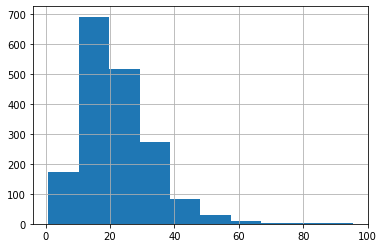

In [79]:
Data_Essay_01['Connectivity_Index'].hist()

In [80]:
Data_Essay_01.to_csv("Output_4.csv")
files.download('/content/Output_4.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Readibility Scores**

We section will cover:
1.   Flesch Reading Ease
2.   Flesch-Kincaid Grade Level
3.   Gunning Fog Index
4.   Dale Chall Readability Formula

In [81]:
#Required Pre-processing for Readability Scores.
Data_Essay_01["Preprocessed_Essay"] = Data_Essay_01["Essay"].apply(Remove_NER2)
Data_Essay_01["Preprocessed_Essay"] = Data_Essay_01["Preprocessed_Essay"].apply(LowerCase_Words)

In [82]:
Data_Essay_01.head()

,ID,Essay,Rater_1 Score,Rater_2 Score,Total Score,Sent_Count,Word_Count,Char_Count,Avg_Word_Count,Avg_Sentence_Length,...,Count_Exclamation,Count_Comma,Count_Questionmark,Count_Hyphens,Capitalization_Errors,Grammar_Error_Count,Grammar_Error_List,Sentences_Tokenized,Semantic_Similarity,Connectivity_Index
0,1,"Dear local newspaper, I think effects computer...",4.0,4.0,8.0,16,386,1875,3.984456,24.125000,...,4,18,2,1,2,2,"[CAUSE_BECAUSE, BE_VBP_IN]","[Dear local newspaper, I think effects compute...",0.291843,24.552787
1,2,"Dear @CAPS1 @CAPS2, I believe that using compu...",5.0,4.0,9.0,20,464,2288,4.030172,23.200000,...,1,12,1,0,0,4,"[ON_COMPOUNDS, NODT_DOZEN, YOU_HAV, DT_DT]","[Dear @CAPS1 @CAPS2, I believe that using comp...",0.386931,25.344232
2,3,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4.0,3.0,7.0,14,313,1541,4.035144,22.357143,...,0,9,0,0,1,5,"[THE_SUPERLATIVE, PHRASE_REPETITION, ITS_TO_IT...","[Dear, @CAPS1 @CAPS2 @CAPS3 More and more peop...",0.419206,14.662850
3,4,"Dear Local Newspaper, @CAPS1 I have found that...",5.0,5.0,10.0,27,611,3165,4.328969,22.629630,...,2,13,1,0,1,0,[],"[Dear Local Newspaper, @CAPS1 I have found tha...",0.338026,32.408323
4,5,"Dear @LOCATION1, I know having computers has a...",4.0,4.0,8.0,30,517,2569,4.071567,17.233333,...,0,13,0,0,1,1,[ARN_T],"[Dear @LOCATION1, I know having computers has ...",0.344825,27.824804


### Flesch Reading Ease Score
    In the Flesch reading-ease test, higher scores indicate material that is easier to read; lower numbers mark passages that are more difficult to read

In [83]:
def Flesch_Reading_Ease_Score(syllable_Count,NoOfsentences,total_Words):
  return (206.835-1.015*(total_Words/float(NoOfsentences))-84.6*(syllable_Count / float(total_Words)))

In [84]:
Data_Essay_01['Flesch_Reading_Ease_Score']=Data_Essay_01.apply(lambda row :Flesch_Reading_Ease_Score(row["Syllable_Count"],row["Sent_Count"],row["Word_Count"]),axis=1)

### Flesch-Kincaid Grade
    Used extensively in educational fields.
  
    It can also mean the number of years of education generally required to understand this text, relevant when the formula results in a number greater than 10.
    
    For example, a score of 9.3 means that a ninth grader would be able to read the document.






In [85]:
def Flesh_Kincaid_Grade(total_Words,total_Sentences,syllable_Count):
   F = float(0.39 * (total_Words / total_Sentences) + 11.8 * (syllable_Count / float(total_Words)) - 15.59)
   return F

In [86]:
Data_Essay_01['Flesh_Kincaid_Grade']=Data_Essay_01.apply(lambda row :Flesh_Kincaid_Grade(row["Syllable_Count"],row["Sent_Count"],row["Word_Count"]),axis=1)

###[Dale-Chall Readability Score](https://www.kaggle.com/code/fshenbayh/readability)
    Provides a numeric gauge of the comprehension difficulty that readers come upon when reading a text
    For example , if score is 4.9 or lower then text is understood by average 4th grade student or lower.







In [87]:
#Raw score = 0.1579*(PDW) + 0.0496*(ASL) if the percentage of PDW is less than 5%, otherwise compute
#Raw score = 0.1579*(PDW) + 0.0496*(ASL) + 3.6365  

def Dale_Challl_Readability_Score(word_Count ,difficult_Words,avg_sent_length):
    NOT_DIFFICULT_WORDS = word_Count - difficult_Words
    if(word_Count >0):
      # Percentage of words not on difficult word list

      percent_Not_Difficult_Words = float(NOT_DIFFICULT_WORDS) / float(word_Count) * 100
        # diff_words stores percentage of difficult words
    diff_words = 100 - percent_Not_Difficult_Words
    Dale_Chall_Score = (0.1579 * diff_words) +  (0.0496 * avg_sent_length)
    if diff_words > 5:      
 
        Dale_Chall_Score += 3.6365
         
    return Dale_Chall_Score




In [88]:
Data_Essay_01['Dale_Challl_Readability_Score']=Data_Essay_01.apply(lambda row :Dale_Challl_Readability_Score(row["Word_Count"],row["Difficult_Word_Count"],row["Avg_Sentence_Length"]),axis=1)

In [89]:
Data_Essay_01.sample

<bound method NDFrame.sample of         ID                                              Essay  Rater_1 Score  \
0        1  Dear local newspaper, I think effects computer...            4.0   
1        2  Dear @CAPS1 @CAPS2, I believe that using compu...            5.0   
2        3  Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...            4.0   
3        4  Dear Local Newspaper, @CAPS1 I have found that...            5.0   
4        5  Dear @LOCATION1, I know having computers has a...            4.0   
...    ...                                                ...            ...   
1778  1783  Dear @CAPS1, @CAPS2 several reasons on way I t...            4.0   
1779  1784  Do a adults and kids spend to much time on the...            3.0   
1780  1785  My opinion is that people should have computer...            4.0   
1781  1786  Dear readers, I think that its good and bad to...            1.0   
1782  1787  Dear - Local Newspaper I agree thats computers...            4.0   

      R

## **Vocabulary Analysis**

In [90]:
#REPEATED PROCESSING AS BAWANY SAID EVERYONE GOT TO DO THEIR OWN PROCESSING.
Data_Essay_01["Preprocessed_Essay"] = Data_Essay_01["Essay"].apply(Remove_NER2)
Data_Essay_01["Preprocessed_Essay"] = Data_Essay_01["Preprocessed_Essay"].apply(LowerCase_Words)
Data_Essay_01["Preprocessed_Essay"] = Data_Essay_01["Preprocessed_Essay"].apply(Remove_Punctuations)

### Lexical Diversity ( Ratio of Unique Words to Total Number of Words ) 

In [91]:
lemmatizer = WordNetLemmatizer()

def Unique_Words_Per_Essay(text):

  token_words = word_tokenize(text)

  #Perform lemma on token_words( since Continous and Continuously are both one uniquen word) and then join them as a sentence.

  unique_words_lemma=[]
  for unique in token_words:
    unique_words_lemma.append(lemmatizer.lemmatize(unique, 'v'))
    unique_words_lemma.append(" ")
  lemma_words= "".join(unique_words_lemma)

  #COUNT ALL UNIQUE WORDS IN LEMMATIZED WORDS
  unique_words = set(lemma_words.split())

  #Neglect all the misspelt words
  correct_unique_words=[]

  for unique in unique_words:
    word = Word(unique)
    result = word.spellcheck()

  # #   # result [0][0] contains the bool value if the spelling is correct or not
  # #   # result [0][1] contains the confidence for the suggest correct spelling

    if word == result[0][0]:
        correct_unique_words.append(word)
  length = len(correct_unique_words)

  return length

def Ratio_Lexical_Diversity(Length_Unique_Words,Word_Count):
    return Length_Unique_Words/Word_Count


In [92]:
Data_Essay_01["Unique_Words_LD"]=Data_Essay_01["Preprocessed_Essay"].apply(Unique_Words_Per_Essay) #Simple Count
Data_Essay_01["Lexical_Diversity"]=Data_Essay_01.apply(lambda row :Ratio_Lexical_Diversity(row["Unique_Words_LD"],row["Word_Count"]),axis=1) #Ratio


In [93]:
Data_Essay_01

,ID,Essay,Rater_1 Score,Rater_2 Score,Total Score,Sent_Count,Word_Count,Char_Count,Avg_Word_Count,Avg_Sentence_Length,...,Grammar_Error_Count,Grammar_Error_List,Sentences_Tokenized,Semantic_Similarity,Connectivity_Index,Flesch_Reading_Ease_Score,Flesh_Kincaid_Grade,Dale_Challl_Readability_Score,Unique_Words_LD,Lexical_Diversity
0,1,"Dear local newspaper, I think effects computer...",4.0,4.0,8.0,16,386,1875,3.984456,24.125000,...,2,"[CAUSE_BECAUSE, BE_VBP_IN]","[Dear local newspaper, I think effects compute...",0.291843,24.552787,86.789576,5.484289,6.551183,143,0.370466
1,2,"Dear @CAPS1 @CAPS2, I believe that using compu...",5.0,4.0,9.0,20,464,2288,4.030172,23.200000,...,4,"[ON_COMPOUNDS, NODT_DOZEN, YOU_HAV, DT_DT]","[Dear @CAPS1 @CAPS2, I believe that using comp...",0.386931,25.344232,79.907259,5.122937,6.726940,159,0.342672
2,3,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4.0,3.0,7.0,14,313,1541,4.035144,22.357143,...,5,"[THE_SUPERLATIVE, PHRASE_REPETITION, ITS_TO_IT...","[Dear, @CAPS1 @CAPS2 @CAPS3 More and more peop...",0.419206,14.662850,80.081797,4.728247,7.015542,131,0.418530
3,4,"Dear Local Newspaper, @CAPS1 I have found that...",5.0,5.0,10.0,27,611,3165,4.328969,22.629630,...,0,[],"[Dear Local Newspaper, @CAPS1 I have found tha...",0.338026,32.408323,84.865926,4.821414,7.214003,184,0.301146
4,5,"Dear @LOCATION1, I know having computers has a...",4.0,4.0,8.0,30,517,2569,4.071567,17.233333,...,1,[ARN_T],"[Dear @LOCATION1, I know having computers has ...",0.344825,27.824804,81.834076,2.236540,6.354310,168,0.324952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1778,1783,"Dear @CAPS1, @CAPS2 several reasons on way I t...",4.0,4.0,8.0,21,548,2590,3.824818,26.095238,...,2,"[COMP_THAN, IT_VBZ]","[Dear @CAPS1, @CAPS2 several reasons on way I ...",0.291333,23.813313,86.639939,6.335905,6.141006,175,0.319343
1779,1784,Do a adults and kids spend to much time on the...,3.0,4.0,7.0,18,235,1091,3.795745,13.055556,...,2,"[A_MD_VB, THERE_S_MANY]",[Do a adults and kids spend to much time on th...,0.279513,13.796213,94.943611,0.467105,5.829460,97,0.412766
1780,1785,My opinion is that people should have computer...,4.0,4.0,8.0,18,314,1642,4.305732,17.444444,...,5,"[PRP_THE, DT_PRP, I_DONT_DT, HE_VERB_AGR, A_LO...",[My opinion is that people should have compute...,0.462623,9.105929,80.549908,2.335711,5.909770,91,0.289809
1781,1786,"Dear readers, I think that its good and bad to...",1.0,1.0,2.0,1,16,71,3.562500,16.000000,...,0,[],"[Dear readers, I think that its good and bad t...",0.000000,3.000000,95.420000,1.918889,6.403850,14,0.875000


### Lexical Density (Number of content words like POS tags)

In [94]:
def Lexical_Density_Per_Essay(Verb_Count,Adj_Count,Conj_Count,Noun_Count,Adv_Count,pNoun_Count):
  sum =0
  sum=sum+Verb_Count+Adj_Count+Conj_Count+Noun_Count+Adv_Count+pNoun_Count
  return sum;

In [95]:
Data_Essay_01["Lexical_Density"]=Data_Essay_01.apply(lambda row :Lexical_Density_Per_Essay(row["Verb_Count"],row["Adj_Count"],row["Conj_Count"],row["Noun_Count"],row["Adverb_Count"],row["pNoun_Count"]),axis=1)


### Lexical Accuracy (Number of errors) **(Incomplete)** 

In [ ]:
#LEAVE IT FOR LATER, WHEN WE WILL RUN THE NOTEBOOK FOR SPELLING AND GRAMMER MISTAKES THEN I WILL CALCULATE THE LEXICAL ACCURACY.

## **Saving All The Features in a CSV**

In [96]:
print(Data_Essay_01.columns)

Index(['ID', 'Essay', 'Rater_1 Score', 'Rater_2 Score', 'Total Score',
       'Sent_Count', 'Word_Count', 'Char_Count', 'Avg_Word_Count',
       'Avg_Sentence_Length', 'Preprocessed_Essay', 'Syllable_Count',
       'Difficult_Word_Count', 'Verb_Count', 'Noun_Count', 'Adj_Count',
       'Conj_Count', 'Adverb_Count', 'pNoun_Count', 'Spelling_Mistakes_Count',
       'Without_White_Spaces', 'Essay_SpellingCorrected_LT', 'Count_Fullstops',
       'Count_Exclamation', 'Count_Comma', 'Count_Questionmark',
       'Count_Hyphens', 'Capitalization_Errors', 'Grammar_Error_Count',
       'Grammar_Error_List', 'Sentences_Tokenized', 'Semantic_Similarity',
       'Connectivity_Index', 'Flesch_Reading_Ease_Score',
       'Flesh_Kincaid_Grade', 'Dale_Challl_Readability_Score',
       'Unique_Words_LD', 'Lexical_Diversity', 'Lexical_Density'],
      dtype='object')


In [97]:
Data_Essay_01.to_csv("EssaySet01_Features.csv")
files.download('/content/EssaySet01_Features.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Domain Information Content** (Incomplete)
It is perhaps the most marked feature of our model as it tries to understand semantics and information content of an essay. To get this feature working, we first figured out the best essay from each set (highest scored essay) then, we pulled out nouns from that essay. These nouns were served as keywords for the particular domain. Then, we fire these word into 'WordNet' and take out their equivalent. In this way, for each set, we got a bunch of different words, most relevant to its particular domain. Then, we count the number of domain words in the essay provided. 

In [ ]:
temp_df = Data_Essay_01[Data_Essay_01['Total Score'] == max(Data_Essay_01["Total Score"])]
temp_df.head()

In [ ]:
temp_df['Preprocessed_Essay'] = temp_df['Essay'].apply(Remove_NER)
temp_df['Preprocessed_Essay'] = temp_df['Preprocessed_Essay'].apply(Tokenize_Essay)
temp_df.head()

In [ ]:
Nouns_List = []

# Extracting Nouns of Best Essays

def Extract_Nouns(Essay):
  """
    Extract Nouns From an Essay

    Args:
      Essay: Best Essay based on score  
  """
  tagged_doc = nlp(Essay)

  for token in tagged_doc:
    if(token.pos_ =='NOUN'):
      if (not(token in Nouns_List)):
        Nouns_List.append(token)

In [ ]:
temp_df["Preprocessed_Essay"].apply(Extract_Nouns)
Nouns_List

#### Lexical originality(# of words unique to a writer divided by total # of words in a corpous of group of writers(essay set))

In [ ]:
def Total_Word_Count():
  return Data_Essay_01['Word_Count'].sum()   
def Lexical_Originality_Per_Essay(Unique_Words,Total_Words):
    return Unique_Words/Total_Words


In [ ]:
Total=Total_Word_Count()
Data_Essay_01["Lexical_Originality"]=Data_Essay_01.apply(lambda row :Lexical_Originality_Per_Essay(row["Unique_Words_LD"],Total),axis=1)


In [ ]:
Data_Essay_01.to_csv("01_Features.csv")

## **Semantic Similarity with sent2vec** (DON'T RUN)
https://towardsdatascience.com/how-to-compute-sentence-similarity-using-bert-and-word2vec-ab0663a5d64

In [ ]:
!pip install sent2vec

In [ ]:
from scipy import spatial
from sent2vec.vectorizer import Vectorizer

In [ ]:
# Extracting Sentences  
vectorizer = Vectorizer(pretrained_weights = 'distilbert-base-multilingual-cased')

def Extract_Sentences(Essay):
  # print(Essay)
  sentences = sent_tokenize(Essay)
  return sentences

def Apply_Embedding(Sentences):
  vectorizer.run(Sentences, remove_stop_words=['not'], add_stop_words=[])
  vectors_w2v = vectorizer.vectors
  distances = []
  for i in range(len(vectors_w2v) - 1):
    distances.append(spatial.distance.cosine(vectors_w2v[i], vectors_w2v[i+1]))
  Average = sum(distances) / len(distances)

  return Average

Initializing Bert distilbert-base-multilingual-cased
Vectorization done on cpu


Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# **Features Correlation Visualization**

In [ ]:
Data_Essay_01_Features = pd.read_csv("/content/drive/MyDrive/IntelliTech-DataSet/EssaySet01_Features.csv")
Data_Essay_01_Features.head()

In [ ]:
Data_Essay_01_Features["Target_Score"] = Data_Essay_01["Total Score"]
Data_Essay_01_Features["Flesch_Reading_Score"] = Data_Essay_01["Flesch_Reading_Score"]
Data_Essay_01_Features.columns

In [ ]:
Data_Essay_01_Features.drop('Unnamed: 0' , axis = 1 , inplace = True)
Data_Essay_01_Features.drop("Unnamed: 20" , axis = 1, inplace = True)
Data_Essay_01_Features.drop("Unnamed: 18" , axis = 1, inplace = True)

In [ ]:
Data_Essay_01_Features.corr()

In [ ]:
import seaborn as sns

# Plot correlation of essay-length related features
cols = ['Sent_Count', 'Word_Count', 'Char_Count']
#        'Avg_Word_Count',
#        'Verb_Count', 'Noun_Count', 'Adj_Count', 'Conj_Count', 'Adverb_Count',
#        'pNoun_Count', 'Count_Fullstops', 'Count_Exclamation', 'Count_Comma',
#        'Count_Questionmark', 'Count_Hyphens', 'Capitalization_Errors',
#        'Grammar_Error_Count', 'Punctuation_Errors']
        
g = sns.pairplot(Data_Essay_01_Features, hue='Target_Score', vars=cols, plot_kws={"s": 20}, palette="bright")
g.fig.subplots_adjust(top=.93)
g.fig.suptitle('Pairplots of select features', fontsize=16)
plt.show()